In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time t given interest rate r
    """
    return (1+r)**(-t)

In [3]:
discount(10, 0.03)

0.7440939148967249

In [4]:
def pv(l, r):
    """
    l is index by the time, and the vlaues are the amounts of each liability 
    returns the present value of the sequence
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts * l).sum()

In [6]:
liabilities = pd.Series(data = [1, 1.5, 2, 2.5], index = [3, 3.5, 4, 4.5])

In [7]:
pv(liabilities, 0.03)

6.233320315080045

In [8]:
def funding_ratio(assets, liabilities, r):
    """
    computes the funding ratio of some asssets given liabilities and interest rate
    """
    return assets/pv(liabilities, r)

In [9]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

In [10]:
funding_ratio(5, liabilities, 0.02)

0.7720304366941648

In [13]:
import ipywidgets as widgets
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print(f'{fr * 100 : .2f}')

controls = widgets.interactive(show_funding_ratio, assets = widgets.IntSlider(min = 1, max = 10, step = 1, value = 5), r = (0, 0.20, 0.01))
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# CIR model to simulate changes in interest rates

In [15]:
def inst_to_ann(r):
    """
    Converts short rate to an annualised rate
    """
    return np.expm1(r)  # exp(r) -1

def ann_to_inst(r):
    """
    Convert annualised to a short rate
    """
    return np.log1p(r)  # log(1+r)

In [23]:
ann_to_inst(0.03)

0.0295588022415444

In [29]:
import math
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    """
    implement the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year    
    num_steps = int(n_years * steps_per_year) + 1
    
    shock = np.random.normal(0, scale = np.sqrt(dt), size = (num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    h = math.sqrt(a**2 + 2 * sigma **2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))** (2*a*b/sigma**2)
        _B = (2* (math.exp(h*ttm) -1))/ (2*h + (h+a)* (math.exp(h*ttm)-1))
        _P = _A * np.exp(-_B * r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step - 1]
        d_r_t = a * (b - r_t)* dt + sigma * np.sqrt(r_t) * shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years - step*dt, rates[step])
        
    rates = pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))
    prices = pd.DataFrame(data = prices, index = range(num_steps))
    return rates, prices

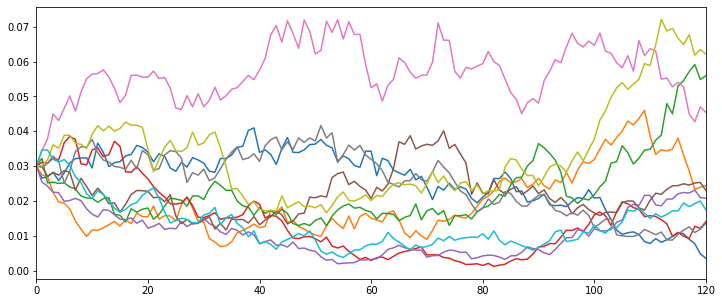

In [36]:
cir(n_scenarios = 10)[0].plot(figsize = (12, 5), legend = False)

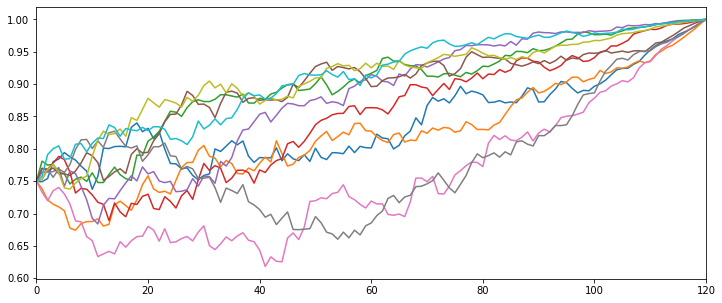

In [46]:
cir(n_scenarios = 10)[1].plot(figsize = (12, 5), legend = False)

In [31]:
def show_cir_prices(r_0 = 0.03, a = 0.5, b = 0.03, sigma = 0.05, n_scenarios = 5):
    cir(r_0 = r_0, a = a, b = b, sigma = sigma, n_scenarios = n_scenarios)[1].plot(legend = False, figsize = (12,5))
        
controls = widgets.interactive(show_cir_prices,
                               r_0 = (0, .15, .01), 
                               a = (0, 1, .1), 
                               b= (0, .15, .01), 
                               sigma = (0, .1, .01), 
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [33]:
a_0 = 0.75 # cash on hand
rates, bond_prices = cir(n_years = 10, r_0 = 0.03, b = 0.03, n_scenarios = 10)
liabilities = bond_prices

zcbond_10 = pd.Series(data = [1], index = [10])   # price is 1 10 years from now
zc_0 = erk.pv(zcbond_10, r = 0.03)  # zero-coupon bonds
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices  # asset value on hand


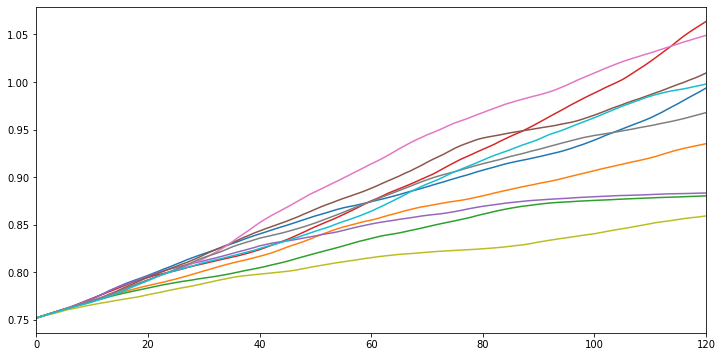

In [34]:
av_cash = a_0 * (rates/12 + 1).cumprod()
av_cash.plot(legend = False, figsize = (12,6))

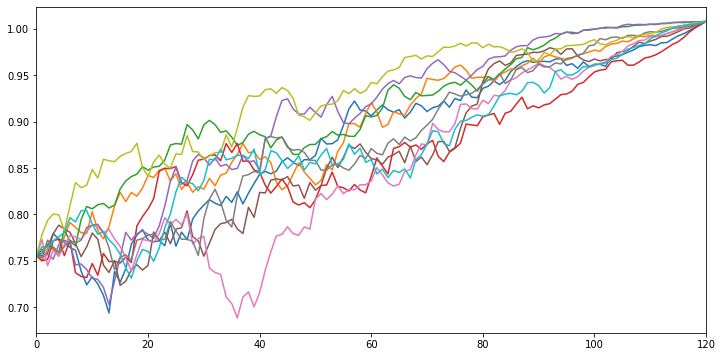

In [37]:
av_zc_bonds.plot(legend = False, figsize = (12,6))

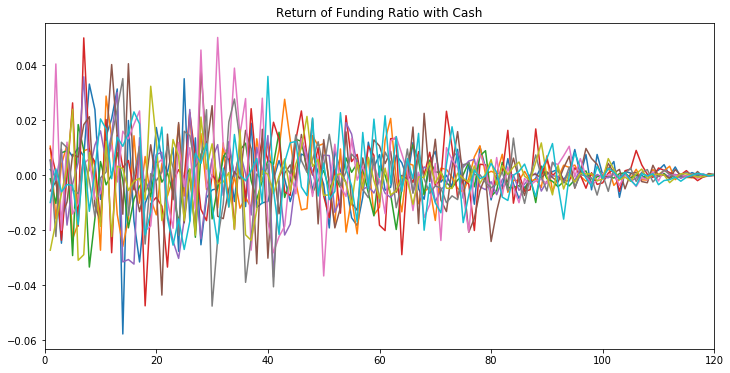

In [40]:
(av_cash/liabilities).pct_change().plot(title = 'Return of Funding Ratio with Cash', legend = False, figsize = (12, 6))

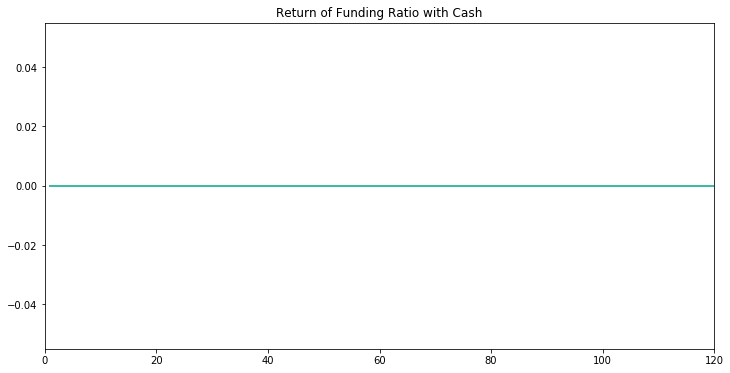

In [41]:
(av_zc_bonds/liabilities).pct_change().plot(title = 'Return of Funding Ratio with zero-coupon bonds', legend = False, figsize = (12, 6))

In [42]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios = 10000, r_0 = 0.03, b = 0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0 / zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (rates / 12 + 1).cumprod()


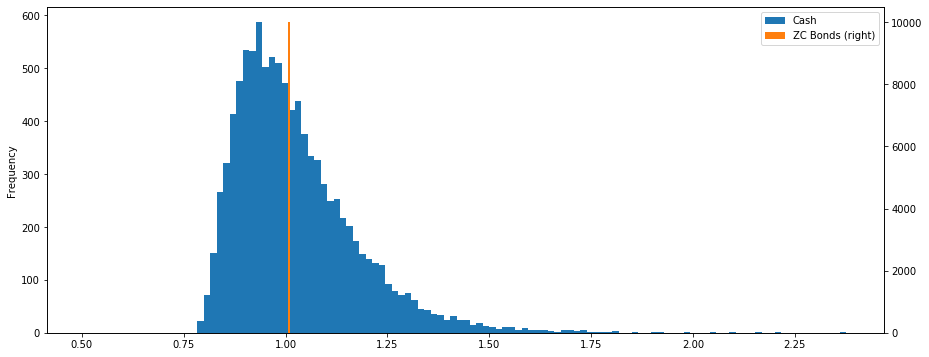

In [45]:
#terminal funding ratio
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label = 'Cash', figsize = (15, 6), bins = 100, legend = True)
tfr_zc_bonds.plot.hist(ax = ax, label = "ZC Bonds", bins = 199, legend = True, secondary_y = True)

# GHP construction with duration matching

In [47]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [48]:
erk.bond_price(20, 1000, 0.05, 2, .04) # interest rate falls below coupon rate

1136.7773962036904

In [50]:
erk.bond_price(20, 1000, 0.05, 2, .05) # interest rate = coupon rate, same return

1000.0000000000023

In [51]:
rates = np.linspace(0.01, 0.10, num = 20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [52]:
prices = [erk.bond_price(10, 100, .05, 2, rate) for rate in rates]
prices

[137.97483829333993,
 132.67629283179224,
 127.61632981372745,
 122.7833537616068,
 118.16636507727874,
 113.75492793724406,
 109.53913999300187,
 105.50960377089511,
 101.6573996722816,
 97.97406048086303,
 94.45154728963504,
 91.08222676519944,
 87.85884967212596,
 84.774530584692,
 81.82272871767958,
 78.99722981198866,
 76.29212901465672,
 73.70181469646424,
 71.22095315367838,
 68.84447414364999]

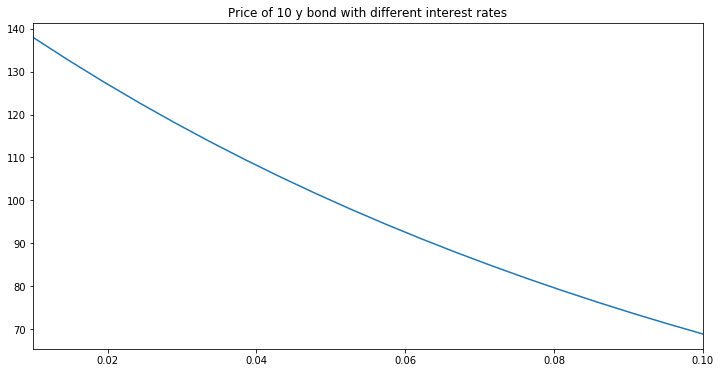

In [54]:
pd.DataFrame(data = prices, index = rates).plot(title = "Price of 10 y bond with different interest rates", legend = False, figsize  = (12,6))

In [56]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [59]:
#discounted cashflow
discounts = erk.discount(cf.index, .06/2)
dcf = discounts * cf
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [60]:
weights = dcf/dcf.sum()
weights

1    0.029126
2    0.028278
3    0.027454
4    0.026655
5    0.025878
6    0.862609
dtype: float64

In [62]:
# (Macaulay duration) weighted average duration.  
# This is directly related to the rate of change, the first derivative of the price with respect to interest rates.
(cf.index * weights).sum()  

5.579707187194534

In [63]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), .06/2)

5.579707187194534

In [73]:
liabilities = pd.Series(data = [100000, 100000], index= [10,12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

In [66]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)
md_10, md_20

(8.190898824083233, 13.544718122145921)

In [67]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

In [69]:
p_short = erk.bond_price(10, 1000, .05, 1, .04)
p_long = erk.bond_price(20, 1000, .05, 1, .04)
a_0 = 130000
p_flows = pd.concat([a_0 * w_s / p_short * short_bond , a_0 * (1 - w_s) / p_long * long_bond ])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [74]:
cfr = erk.funding_ratio(p_flows, liabilities, .04)
cfr

0.9998760012192478

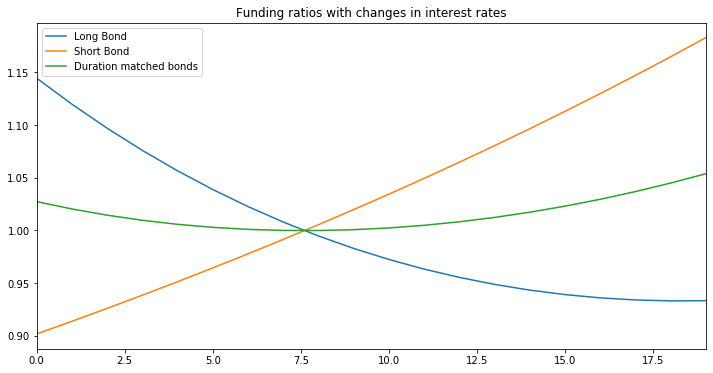

In [75]:
rates = np.linspace(0, .1, 20)
lb_assets = a_0 * long_bond / p_long
sb_assets = a_0 * short_bond / p_short

fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration matched bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates]
})

fr_change.plot(title = "Funding ratios with changes in interest rates", figsize = (12, 6))